In [1]:
import numpy as np
import hls4ml
import qkeras
import tensorflow as tf

from qkeras import *
from qkeras import QDense, QActivation, QBatchNormalization, quantized_bits
from qkeras.utils import load_qmodel
from tensorflow import keras
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation
from tensorflow.keras import layers, models

/afs/cern.ch/work/a/adpol/L1CaloTriggerAD/synthesis/hls4ml/converters/__init__.py:15: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [2]:
# Define the test vector; or reuse the old one

# test_vector = np.random.randint(0, 1024, 252) + 0.
# test_vector = test_vector.reshape(1, 252)

test_vector = np.array(
    [
        [310.,  232.,  288.,  796.,  557.,  540.,   37.,  461.,  281.,
         800.,  385.,  117.,  700.,  940.,  181.,  892.,  335.,  723.,
         349.,  385.,  195.,  707.,   49.,  769.,  922.,  559., 1011.,
         839.,  262.,   36.,  994.,  327., 1023.,  109.,  585.,  715.,
         205.,  327.,  872.,  155.,   51.,  152.,  797.,  278.,   71.,
         1002.,  303.,  477.,  442.,  882.,  656.,  666.,  378., 1008.,
         284.,   77.,  966.,  988.,  502.,  540., 1014.,  846.,  829.,
         259.,  231., 1009.,  377.,   99.,  257.,  321.,  848.,  888.,
         1000.,  637.,  780.,   82.,   90.,  453.,  285.,  477.,  653.,
         247.,  343.,  100.,   23.,  288.,  391.,  153.,  501.,   52.,
         70.,   33.,  326.,  589.,  440.,  905.,  833.,   51.,  332.,
         856.,  766.,  195.,  655.,  811.,  804.,  868.,  678.,  293.,
         442.,  469.,  575.,  360.,  164.,  530.,  554.,   72.,  527.,
         630.,   63.,  381.,  790.,  245.,  379.,  938.,  735.,  527.,
         408.,  548.,  881.,  933.,  358.,  906.,  977.,  355.,  353.,
         380.,  453.,   85.,  502.,   73.,  165.,  853.,  149.,  288.,
         1022.,  658.,  747.,  241.,  354.,   28.,  104.,   14.,  699.,
         73.,  132.,  609.,  794.,  134.,  442.,  740.,  329.,  900.,
         232., 1023.,  571.,  178.,  609.,   49.,  787.,  847.,  314.,
         269.,  528.,  528.,  418.,   25.,   58.,  972.,  376.,  670.,
         125.,  381.,  382., 1015.,  111.,  502.,  119.,  126.,  871.,
         385.,  417.,  720.,   22.,  170.,  460.,  979.,  228.,  660.,
         495.,  235.,  309.,  826.,  334.,  404.,  673.,  371.,  208.,
         813.,  423.,  526.,  858.,  133.,  675.,  139.,    3.,  532.,
         731.,   54.,    5.,  239.,  308.,   57.,  144.,  307.,  685.,
         751.,  897.,  338.,  899.,  646.,  876.,   47.,  186.,  647.,
         533.,   23.,  567.,  182.,  203.,  694.,  133.,  964.,  189.,
         126.,  809.,  133.,  767.,  693.,  379.,    6.,  333.,  382.]
    ]
)

In [3]:
model = load_qmodel('qmodel')

inputs = Input(shape = (252,), name="Inputs")
dense_1 = model.layers[2](inputs)
#qbn = model.layers[3](dense_1)
# qbn = BatchNormalization(name="QBN_1")(dense_1)
act = model.layers[4](dense_1)
out = model.layers[5](act)

student = Model(inputs, out, name='student')
student.summary()

2022-08-26 18:04:38.429483: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-26 18:04:38.429602: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lxplus710.cern.ch): /proc/driver/nvidia/version does not exist
2022-08-26 18:04:38.699015: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "student"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Inputs (InputLayer)          [(None, 252)]             0         
_________________________________________________________________
Dense_1 (QDense)             (None, 15)                3780      
_________________________________________________________________
Activation_1 (QActivation)   (None, 15)                0         
_________________________________________________________________
Out (QDense)                 (None, 1)                 15        
Total params: 3,795
Trainable params: 3,795
Non-trainable params: 0
_________________________________________________________________


In [4]:
hls4ml.model.optimizer.get_optimizer(
    'output_rounding_saturation_mode'
).configure(
    layers=['Activation_1'],
    rounding_mode='AP_RND',
    saturation_mode='AP_SAT',
    saturation_bits='AP_SAT'
)

# Create hls4ml config
hls_config = hls4ml.utils.config_from_keras_model(student, granularity='name')

# Set the model config
hls_config['Model']['ReuseFactor'] = 3
hls_config['Model']['Strategy'] = 'Resource'
hls_config['Model']['ClockPeriod']  = 6.25
hls_config['Model']['Trace']  = True

# Create an entry for each layer
for Layer in hls_config['LayerName'].keys():

    if Layer == 'Inputs':
        hls_config['LayerName'][Layer]['Precision']['accum'] = 'ap_ufixed<10, 10>'
        hls_config['LayerName'][Layer]['Precision']['result'] = 'ap_ufixed<10, 10>'

    if Layer == 'Dense_1':
        hls_config['LayerName'][Layer]['Precision']['accum'] = 'ap_fixed<20, 18>'
        hls_config['LayerName'][Layer]['Precision']['result'] = 'ap_fixed<20, 18>'
    if Layer == 'Dense_1_linear':
        hls_config['LayerName'][Layer]['Precision'] = 'ap_fixed<20, 18>'

    if Layer == 'QBN_1':
        hls_config['LayerName'][Layer]['Precision']['accum'] = 'ap_fixed<20, 10>'
        hls_config['LayerName'][Layer]['Precision']['result'] = 'ap_fixed<20, 10>'
        
    if Layer == 'Activation_1':
        hls_config['LayerName'][Layer]['Precision']['result'] = 'ap_ufixed<5, 2>'

    if Layer == 'Out':
        hls_config['LayerName'][Layer]['Precision']['accum'] = 'ap_fixed<16, 5>'
        hls_config['LayerName'][Layer]['Precision']['result'] = 'ap_fixed<16, 5>'
    if Layer == 'Out_linear':
        hls_config['LayerName'][Layer]['Precision'] = 'ap_fixed<16, 5>'

    hls_config['LayerName'][Layer]['Strategy'] = 'Resource'
    hls_config['LayerName'][Layer]['ReuseFactor'] = 3
    hls_config['LayerName'][Layer]['Trace'] = True
    
# Finish setting up the config
cfg = hls4ml.converters.create_config(part="xc7vx690tffg1927-2")
cfg['IOType'] = 'io_parallel'
cfg['HLSConfig'] = hls_config
cfg['KerasModel'] = student
cfg['ClockPeriod']  = 6.25
cfg['OutputDir']  = 'CaloADTrigger/'
cfg['Part'] = 'xc7vx690tffg1927-2'

Interpreting Model
Topology:
Layer name: Inputs, layer type: Input
Layer name: Dense_1, layer type: QDense
  -> Activation (linear), layer name: Dense_1
Layer name: Activation_1, layer type: QActivation
  -> Activation (quantized_relu(5,2)), layer name: Activation_1
Layer name: Out, layer type: QDense
  -> Activation (linear), layer name: Out


In [5]:
# Compile the model

hls_model = hls4ml.converters.keras_to_hls(cfg)
hls4ml.model.optimizer.get_optimizer(
    'output_rounding_saturation_mode'
).configure(layers=[])
hls_model.compile()

Interpreting Model
Topology:
Layer name: Inputs, layer type: InputLayer, input shapes: [[None, 252]], output shape: [None, 252]
Layer name: Dense_1, layer type: QDense, input shapes: [[None, 252]], output shape: [None, 15]
Layer name: Activation_1, layer type: Activation, input shapes: [[None, 15]], output shape: [None, 15]
Layer name: Out, layer type: QDense, input shapes: [[None, 15]], output shape: [None, 1]
Creating HLS model
Writing HLS project


Done


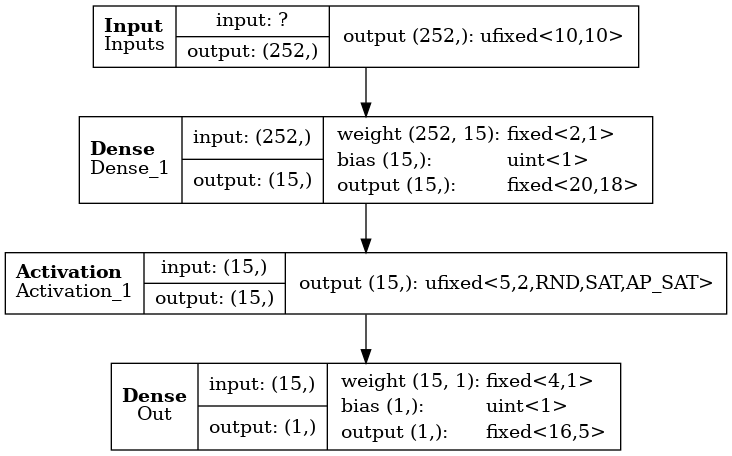

In [6]:
hls4ml.utils.plot_model(
    hls_model,
    show_shapes=True,
    show_precision=True,
    to_file=None
)

In [7]:
hls_model.predict(test_vector)

array([10.171875])

In [8]:
student.predict(test_vector)

2022-08-26 18:05:07.289926: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


array([[10.171875]], dtype=float32)

In [9]:
hls_model.predict(test_vector) -  student.predict(test_vector)

array([[0.]])

In [10]:
hls4ml_pred, hls4ml_trace = hls_model.trace(test_vector)

Recompiling myproject with tracing
Writing HLS project


Done


In [11]:
hls4ml_trace

{'Dense_1': array([[  1949. , -12148.5,  38461.5, -41044.5,  34067. ,  43674.5,
         -32010.5,  31962.5, -43711.5,  16183. ,  35914. , -14119.5,
          18284. ,  -3413. ,  36540. ]]),
 'Activation_1': array([[3.875, 0.   , 3.875, 0.   , 3.875, 3.875, 0.   , 3.875, 0.   ,
         3.875, 3.875, 0.   , 3.875, 0.   , 3.875]]),
 'Out': array([[10.171875]])}

In [12]:
# keras_trace = hls4ml.model.profiling.get_ymodel_keras(model, test_vector.reshape(1, 18, 14))

In [13]:
# hls4ml_trace['Dense_1']

In [14]:
# keras_trace['Dense_1']

In [15]:
# hls4ml_trace['QBN_1']

In [16]:
# keras_trace['QBN_1']

In [17]:
# hls4ml_trace['Activation_1']

In [18]:
# keras_trace['Activation_1']

In [19]:
# hls4ml_trace['Out']

In [20]:
# keras_trace['Out']

# Synthesis

In [49]:
# Change the uncertainty in tcl: set_clock_uncertainty 30% {get_clocks default}

!grep -n create_clock CaloADTrigger/build_prj.tcl | awk -F ":" '{print$1}' | ( read line; echo "$((line + 1)) ") | xargs -I {} sed -i '{} i set_clock_uncertainty 30% {get_clocks default}' CaloADTrigger/build_prj.tcl 

In [48]:
# Run Vivado HLS

!vivado_hls -f CaloADTrigger/build_prj.tcl "reset=1 synth=1 csim=0 cosim=0 validation=0 export=0 vsynth=0"

168 


In [ ]:
# Get the report

!cat CaloADTrigger/myproject_prj/solution1/syn/report/myproject_csynth.rpt